# Groverのアルゴリズムのチュートリアル(Qiskit v1.x)
$n$=4 量子ビットの場合のGroverの探索アルゴリズムの実装例。

## 0. 必要なライブラリのimport 

In [1]:
# Jupyter Notebook や IPython 環境でグラフをインライン表示するための設定
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib # Matplotlibでの日本語表示をサポート
import os # 主にテキスト形式の回路図を保存するフォールバック処理で使用

#(Qiskit v1.x)
from qiskit import QuantumCircuit, transpile # 量子回路の定義と最適化（トランスパイル）
from qiskit.quantum_info import Statevector # 量子状態ベクトルの操作
from qiskit.visualization import plot_histogram # 測定結果のヒストグラム表示
from qiskit.providers.basic_provider import BasicSimulator # 基本的な量子回路シミュレータ
from qiskit.circuit.library import Diagonal # 対角行列からゲートを生成

from IPython.display import display # Jupyter環境でのリッチな表示のため

# 1. 基本パラメータ設定

- $n$ (量子ビット数): 量子情報を保持する基本単位である量子ビットの数。量子ビットが増えるほど、扱える状態空間のサイズが指数関数的に増大。
- $N$ (状態空間のサイズ): $n$ 個の量子ビットで表現できる計算基底状態の総数で、$N=2^n$ となる。
- marked_item_binary (探索対象アイテム): N個の状態の中から探し出したい特定の状態を、2進数文字列で指定。
- (plots_dir: グラフィカルな回路図描画が失敗した場合に、テキストベースの回路図を保存するためのディレクトリ名。プロット画像自体は、実行後すぐに下に表示される。)

In [2]:
# n=4 の例パラメータ
n = 4
N = 2**n
marked_item_binary = '0101' # 探索対象の状態 (2進数で0101は10進数で5)
marked_item_int = int(marked_item_binary, 2)

# プロット保存ディレクトリ (テキスト回路図のフォールバック用)
plots_dir = "grover_plots_n4_interactive_text_fallback"

## 2. 量子状態可視化のためのヘルパー関数
以下に定義する2つの関数は、量子状態の「実数振幅」と「測定確率」をそれぞれ棒グラフで表示するためのもの。


In [4]:
# 量子状態をグラフで表示するためのヘルパー関数を定義

def plot_state_real_amplitudes(statevector, title_prefix, marked_label=None, marked_amplitude_val=None, marked_prob_val=None):
    """指定された量子状態の実数振幅をプロットする。"""
    if not isinstance(statevector, Statevector):
        sv = Statevector(statevector)
    else:
        sv = statevector

    amplitudes_complex = sv.data
    amplitudes_real = np.real(amplitudes_complex)
    state_labels = [format(i, f'0{n}b') for i in range(N)]

    title = title_prefix
    if marked_label:
        title += f"\nマークされた状態 |{marked_label}>: 実数振幅={marked_amplitude_val:.4f}, 確率={marked_prob_val:.4f}"

    fig, ax = plt.subplots(figsize=(14, 7))
    bars = ax.bar(state_labels, amplitudes_real, color='cornflowerblue', width=0.8)

    if marked_label in state_labels:
        marked_idx_for_plot = state_labels.index(marked_label)
        bars[marked_idx_for_plot].set_color('salmon')

    ax.set_xlabel("計算基底状態")
    ax.set_ylabel("実数振幅")
    ax.set_title(title)
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(state_labels, rotation=90)
    ax.axhline(0, color='black', linewidth=0.8)
    min_val = np.min(amplitudes_real)
    max_val = np.max(amplitudes_real)
    ax.set_ylim(min(min_val - 0.1, -0.15) if min_val < 0 else -0.15,
                  max(max_val + 0.1, 0.15) if max_val > 0 else 0.15)
    plt.tight_layout()
    plt.show()
    plt.close(fig)

def plot_state_probabilities(statevector, title_prefix, marked_label=None, marked_amplitude_val=None, marked_prob_val=None):
    """指定された量子状態の測定確率をプロットする。"""
    if not isinstance(statevector, Statevector):
        sv = Statevector(statevector)
    else:
        sv = statevector

    probabilities = sv.probabilities()
    state_labels = [format(i, f'0{n}b') for i in range(N)]

    title = title_prefix
    if marked_label:
         title += f"\nマークされた状態 |{marked_label}>: 実数振幅={marked_amplitude_val:.4f}, 確率={marked_prob_val:.4f}"

    fig, ax = plt.subplots(figsize=(14, 7))
    bars = ax.bar(state_labels, probabilities, color='deepskyblue', width=0.8)

    if marked_label in state_labels:
        marked_idx_for_plot = state_labels.index(marked_label)
        bars[marked_idx_for_plot].set_color('orangered')

    ax.set_xlabel("計算基底状態")
    ax.set_ylabel("測定確率")
    ax.set_title(title)
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(state_labels, rotation=90)
    ax.set_ylim(0, 1.05)
    plt.tight_layout()
    plt.show()
    plt.close(fig)

print("量子状態の可視化用ヘルパー関数の準備完了。")

量子状態の可視化用ヘルパー関数の準備完了。


## 3. ステップ 0: 初期状態の準備 — 均一な重ね合わせ
Groverのアルゴリズムは、まず全ての量子ビットを初期化し、いわゆる「均一な重ね合わせ状態」を生成することから始まる。
これは、探索空間内の全ての計算基底状態が等しい振幅と等しい確率で重ね合わさっている状態を意味する。

この状態を生成するために、通常、各量子ビットにアダマールゲート ($H$) を適用する。</br>
初期状態が $\ket{0}^{\otimes n}$ (全ての量子ビットが $\ket{0}$ である状態) であるとすると、アダマールゲートを全量子ビットに作用させることで、状態は以下のように変化する：
$$H^{\otimes n} \ket{0}^{\otimes n} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1}\ket{x} $$ 
この状態を $\ket{s}$  とも表記する。この時点では、探索対象であるマークされた状態も、他の全ての状態と区別なく振幅 $\frac{1}{\sqrt{N}}$を持っている。

ステップ0: 初期化処理 - 均一な重ね合わせ状態の生成...
全 4 量子ビットにアダマールゲートを適用しました。
初期状態の状態ベクトルを計算しました。

初期状態において、マークされた状態 |0101> は:
  実数振幅 ≈ 0.2500
  測定確率 ≈ 0.0625 (これは 1/N = 0.0625 に対応します)

初期状態の「実数振幅」分布:


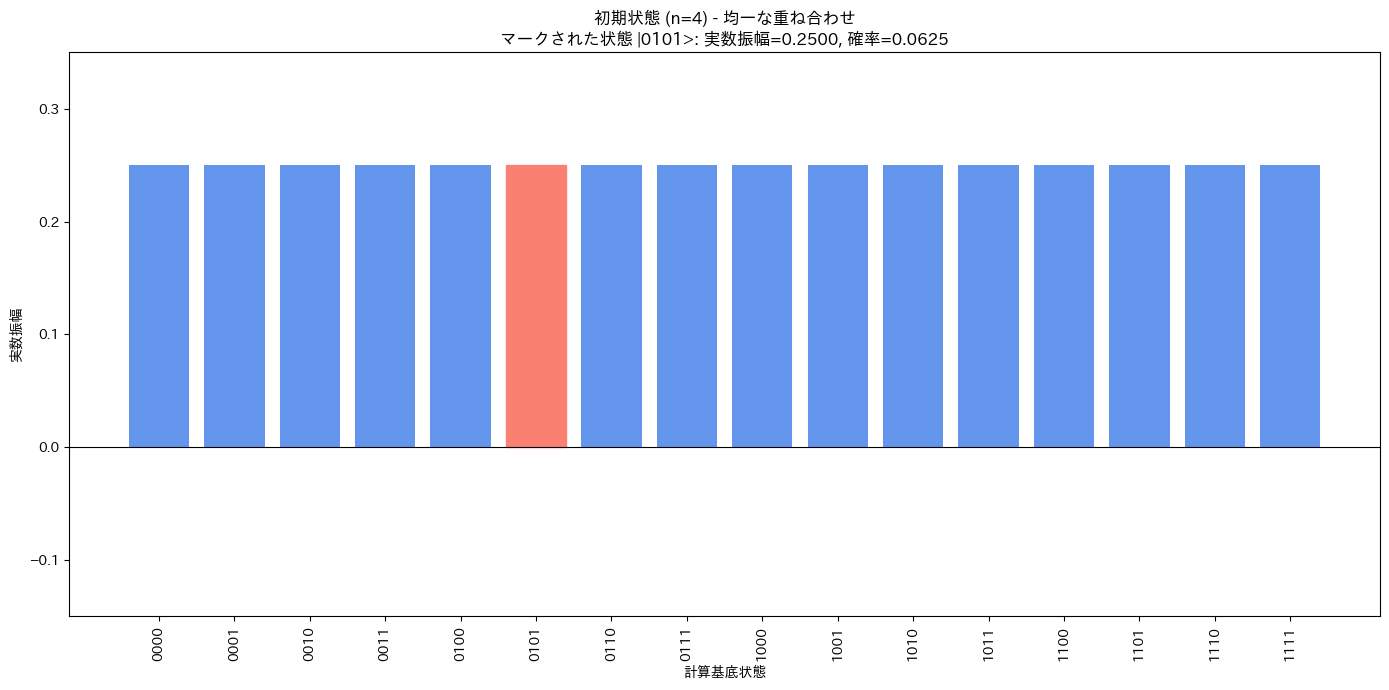


初期状態の「測定確率」分布:


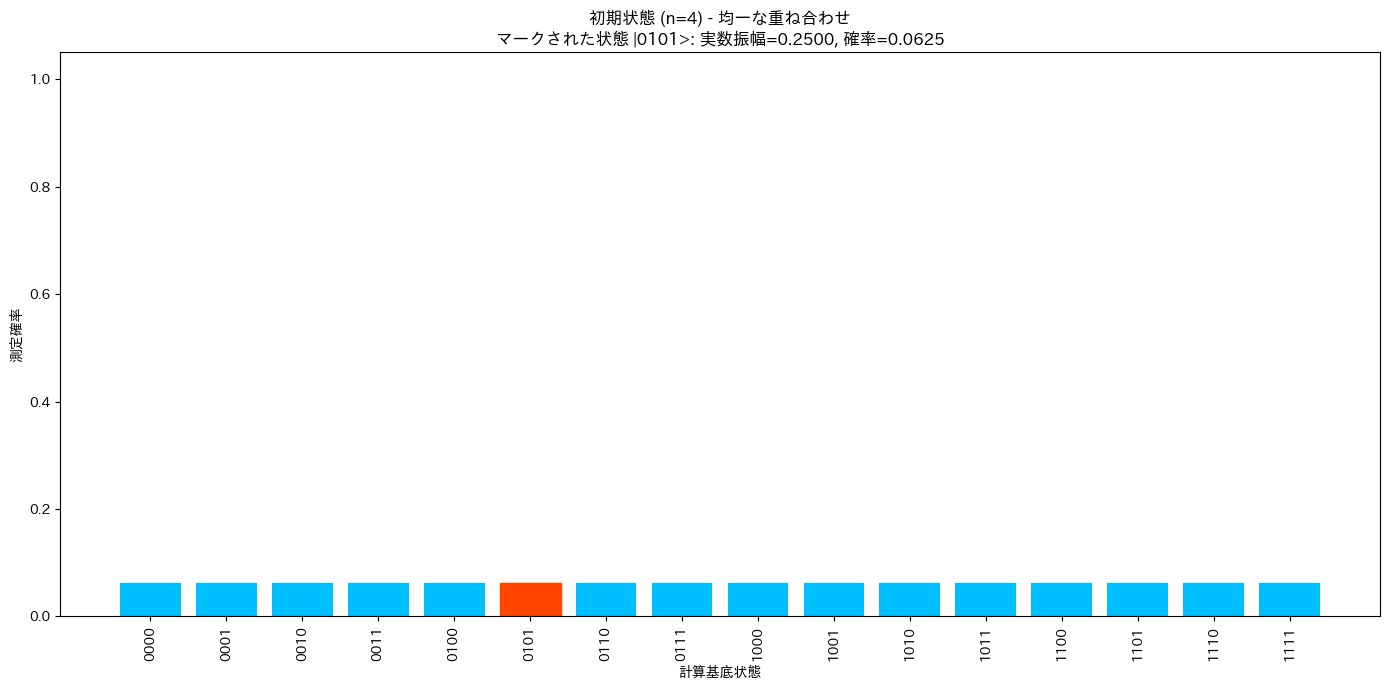


初期化回路の構成図:


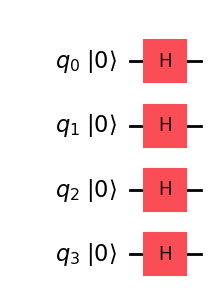


ステップ0完了。この時点では、全ての状態が等しい確率。


In [5]:
# ステップ 0: 量子システムを均一な重ね合わせ状態に初期化 ---
print("ステップ0: 初期化処理 - 均一な重ね合わせ状態の生成...")

# n量子ビットからなる量子回路を定義。
init_qc = QuantumCircuit(n, name="初期化")

# 各量子ビットにアダマールゲート(H)を適用し、均一な重ね合わせにする。
init_qc.h(range(n))
print(f"全 {n} 量子ビットにアダマールゲートを適用しました。")

# この初期化回路によって生成される量子状態（状態ベクトル: StateVector）を取得。
sv_initial = Statevector(init_qc)
print("初期状態の状態ベクトルを計算しました。")

# マークされた状態 |marked_item_binary> の初期振幅と確率を確認。
amp_initial_real = np.real(sv_initial.data[marked_item_int]) # marked_item_int = 0101
prob_initial_marked = sv_initial.probabilities_dict().get(marked_item_binary, 0.0) # .getでキーが存在しない場合のデフォルト値を0.0に

print(f"\n初期状態において、マークされた状態 |{marked_item_binary}> は:")
print(f"  実数振幅 ≈ {amp_initial_real:.4f}")
print(f"  測定確率 ≈ {prob_initial_marked:.4f} (これは 1/N = {1/N:.4f} に対応します)")

# 初期状態の振幅と確率をプロット。
print("\n初期状態の「実数振幅」分布:")
plot_state_real_amplitudes(
    sv_initial,
    f"初期状態 (n={n}) - 均一な重ね合わせ",
    marked_label=marked_item_binary,
    marked_amplitude_val=amp_initial_real,
    marked_prob_val=prob_initial_marked
)

print("\n初期状態の「測定確率」分布:")
plot_state_probabilities(
    sv_initial,
    f"初期状態 (n={n}) - 均一な重ね合わせ",
    marked_label=marked_item_binary,
    marked_amplitude_val=amp_initial_real,
    marked_prob_val=prob_initial_marked
)

print("\n初期化回路の構成図:")
try:
    fig = init_qc.draw('mpl', initial_state=True, fold=-1) # initial_state=True で |0...0> からの遷移を表示
    if fig: plt.show(); plt.close(fig)
except Exception as e:
    print(f"回路図の'mpl'描画に失敗しました: {e}. テキスト形式で表示します。")
    print(init_qc.draw(output='text', fold=-1))

print("\nステップ0完了。この時点では、全ての状態が等しい確率。")

プロットが示す通り、初期状態では全ての計算基底状態が等しい実数振幅（この場合は $\frac{1}{\sqrt{16}}=0.25$）と、等しい測定確率（$\frac{1}{16}=0.0625$）を持っている。</br>
今回の探索対象である $\ket{0101}$ も、この時点では他の状態と何ら変わりない。

## 4. ステップ 1: 探索対象のマーキング — オラクル ($U_f$) の適用
Groverのアルゴリズムにおける次なる重要ステップは、「オラクル」と呼ばれる特殊なユニタリ演算子$U_f$の適用である。このオラクルの主な役割は、今回探索している特定のマークされた状態（ここでは $\ket{0101}$）を識別し、それに印をつけること。

この「印をつける」という操作は、具体的にはマークされた状態の位相を反転させるという形で行われる。
つまり、マークされた状態を$\ket{x_M}$とすると、オラクルは $$\ket{x_M} → - \ket{x_M}$$という変換を実行する。

一方で、マークされていない他の全ての状態 $\ket{x} (x≠x_M)$ は何の変化も受けない。この動作は、関数 $f(x)$ を用いて $$ U_f\ket{x} = (-1)^{f(x)}\ket{x}$$と簡潔に記述できる。
ここで、$f(x)$ は状態 $\ket{x}$ がマークされた状態であれば $f(x)=1$ となり、そうでなければ $f(x)=0$ となるような関数である。

この位相の反転自体は、各状態が観測される確率（これは振幅の絶対値の2乗：$\ket{\alpha}^2$ ）を直接変化させるものではない。しかし、この符号の変化が、後続の「振幅増幅」というステップで活きることになる。

Qiskitでは、このような特定の状態の位相を変えるオラクルを、例えば Diagonal ゲート（対角行列で表現されるゲート）などを使って実装可能である。今回は、マークされた状態に対応する対角要素だけが-1で、他は全て1であるような対角行列を考え、それを量子回路に組み込む。

ステップ1: オラクル演算の適用...
状態 |0101> のみ位相を反転する対角行列の要素を準備しました。
オラクルゲートを量子回路に組み込みました。
初期化後の状態にオラクルを適用する回路を構成しました。
オラクル適用後の状態ベクトルを計算しました。

オラクル適用後、状態 |0101> は:
  実数振幅 ≈ -0.2500 (符号が反転したことを確認)
  測定確率 ≈ 0.0625 (確率は変化していない)

オラクル適用後の「実数振幅」分布:


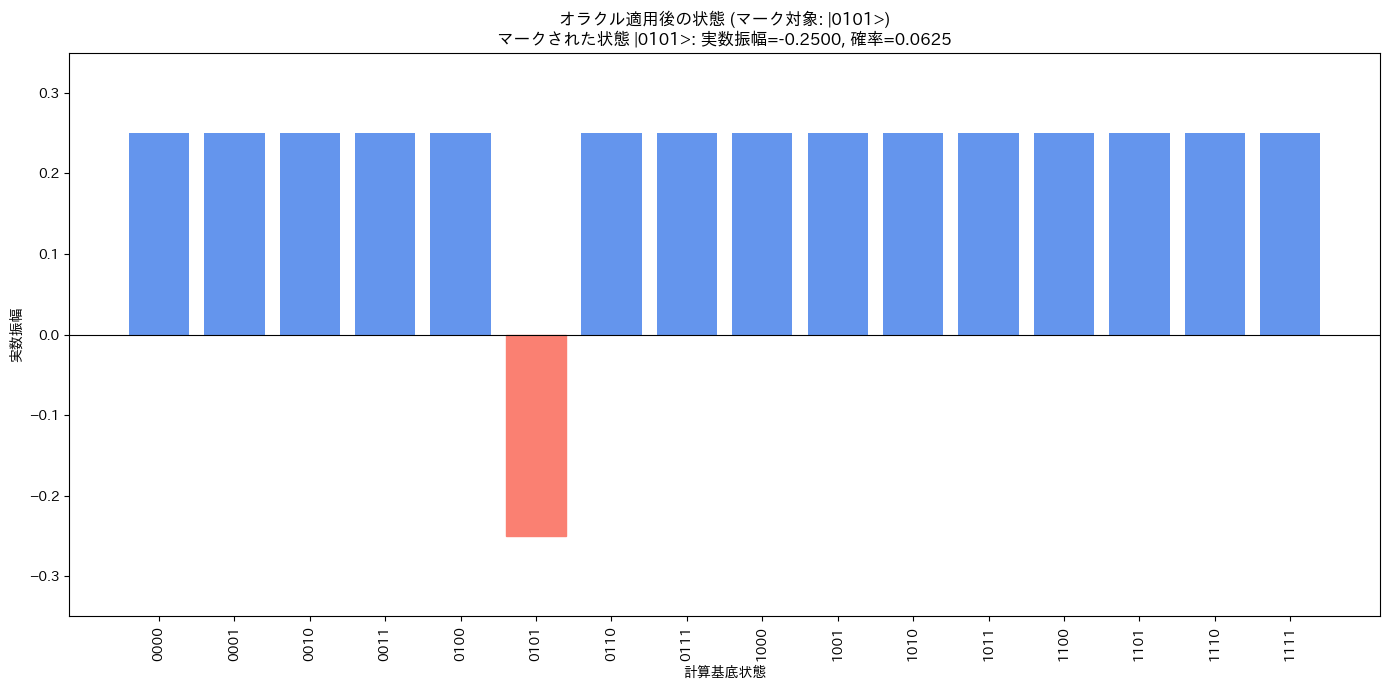


オラクル適用後の「測定確率」分布:


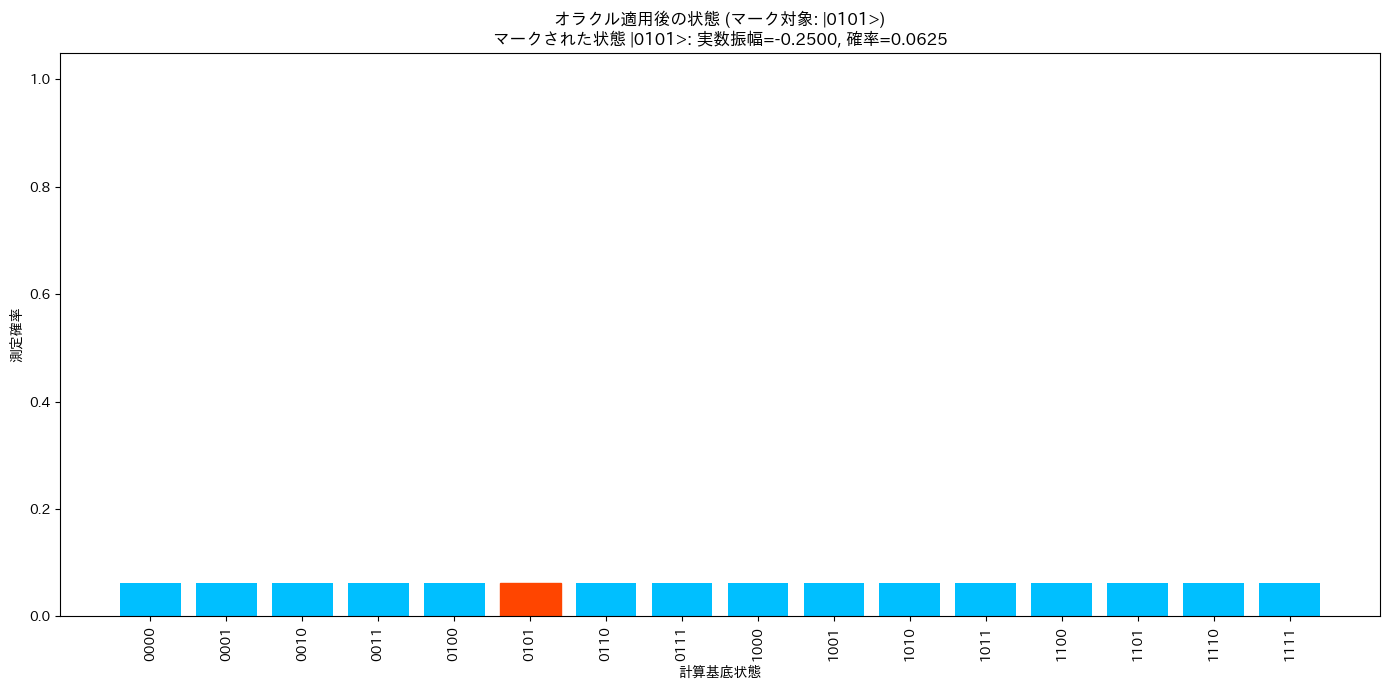


オラクル演算子 U_f の回路図:


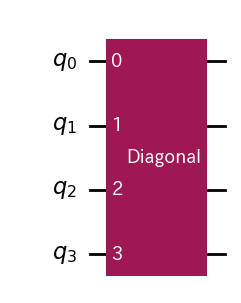


オラクル回路を基本ゲートセット ['cx', 'x', 'z', 'h', 's', 't', 'sdg', 'rz'] にトランスパイルします...

▼ Uゲートを使わずに基本ゲートだけで表現したオラクル回路
描画に成功しました。回路が長いため、画像の一部のみが表示されている可能性があります。


/usr/local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:267: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /usr/local/lib/python3.10/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


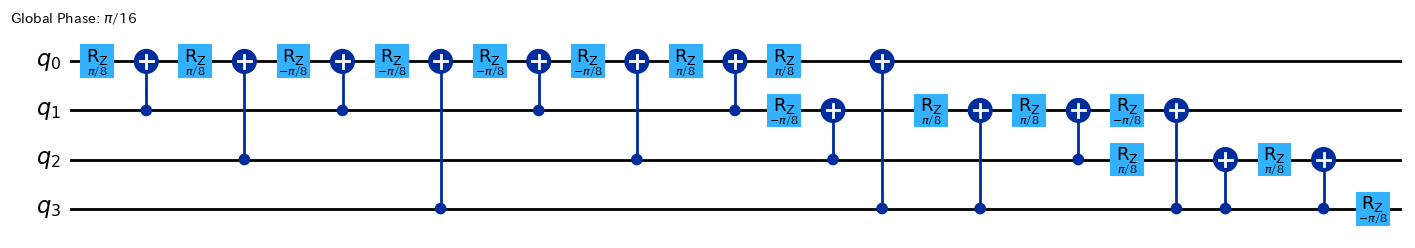


 ここまでの全体の回路図


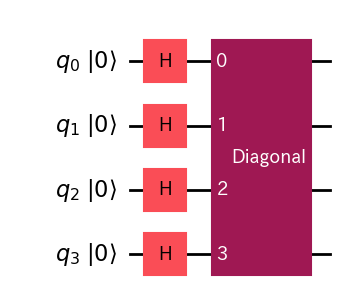


ステップ1完了。マークされた状態 |0101> の位相が反転。


In [23]:
# ステップ 1: マークされた状態の位相を反転させるオラクルを定義し、適用する。
print("ステップ1: オラクル演算の適用...")

# オラクルとして機能する対角行列の要素を定義。
# まず、N x N の単位行列の対角要素のように、全て1で初期化。
oracle_diag_elements = np.ones(N, dtype=complex)
# 次に、マークされた状態 (marked_item_int) に対応する要素の符号を反転させ、-1にする。
oracle_diag_elements[marked_item_int] = -1
print(f"状態 |{marked_item_binary}> のみ位相を反転する対角行列の要素を準備しました。")

# この対角要素から、QiskitのDiagonalゲート（ユニタリ演算子）を生成。これがU_f。
oracle_gate_op = Diagonal(oracle_diag_elements)

# オラクル操作のみを含む量子回路を参考として作成。
oracle_circuit = QuantumCircuit(n, name=f"U_f (Oracle)\nTarget: |{marked_item_binary}>")
oracle_circuit.append(oracle_gate_op, range(n))
print("オラクルゲートを量子回路に組み込みました。")

# 先ほどの均一な重ね合わせ状態 (init_qc) に、このオラクルを適用する。
qc_after_oracle = init_qc.copy() # init_qc の状態から新しい回路を開始
qc_after_oracle.name = "Init + Oracle"
qc_after_oracle.append(oracle_gate_op, range(n)) # オラクルゲートを回路に追加
print("初期化後の状態にオラクルを適用する回路を構成しました。")

# オラクル適用後の状態ベクトルを計算。
sv_after_oracle = Statevector(qc_after_oracle)
print("オラクル適用後の状態ベクトルを計算しました。")

# マークされた状態の振幅と確率がどのように変化したかを確認。
amp_oracle_real = np.real(sv_after_oracle.data[marked_item_int])
prob_oracle_marked = sv_after_oracle.probabilities_dict().get(marked_item_binary, 0.0)

print(f"\nオラクル適用後、状態 |{marked_item_binary}> は:")
print(f"  実数振幅 ≈ {amp_oracle_real:.4f} (符号が反転したことを確認)")
print(f"  測定確率 ≈ {prob_oracle_marked:.4f} (確率は変化していない)")

# オラクル適用後の状態の振幅と確率をプロットします。
print("\nオラクル適用後の「実数振幅」分布:")
plot_state_real_amplitudes(
    sv_after_oracle,
    f"オラクル適用後の状態 (マーク対象: |{marked_item_binary}>)",
    marked_label=marked_item_binary,
    marked_amplitude_val=amp_oracle_real,
    marked_prob_val=prob_oracle_marked
)

print("\nオラクル適用後の「測定確率」分布:")
plot_state_probabilities(
    sv_after_oracle,
    f"オラクル適用後の状態 (マーク対象: |{marked_item_binary}>)",
    marked_label=marked_item_binary,
    marked_amplitude_val=amp_oracle_real,
    marked_prob_val=prob_oracle_marked
)

print("\nオラクル演算子 U_f の回路図:")
try:
    fig = oracle_circuit.draw('mpl', fold=-1)
    if fig: plt.show(); plt.close(fig)
except Exception as e:
    print(f"回路図の'mpl'描画に失敗: {e}. テキスト形式で表示します。")
    print(oracle_circuit.draw(output='text', fold=-1))

# transpile関数を使い、基本的なゲートセットに分解する
basis_gates = ['cx', 'x', 'z', 'h', 's', 't', 'sdg', 'rz']

print(f"\nオラクル回路を基本ゲートセット {basis_gates} にトランスパイルします...")
# transpile関数を使って、指定した基本ゲートのみで回路を再構成
transpiled_oracle = transpile(oracle_circuit, basis_gates=basis_gates, optimization_level=3)

print("\n▼ Uゲートを使わずに基本ゲートだけで表現したオラクル回路")
try:
    # 回路が非常に長くなるため、適度なところで折り返す (fold)
    # style='iqx' などで見栄えを変えることも可能
    fig = transpiled_oracle.draw('mpl', fold=120, style='iqx')
    if fig:
        print("描画に成功しました。回路が長いため、画像の一部のみが表示されている可能性があります。")
        # 画像サイズを調整して表示
        fig.set_size_inches(18, 10)
        plt.show()
        plt.close(fig)
except Exception as e:
    print(f"回路図の'mpl'描画に失敗しました: {e}.")
    print("回路が非常に長いため、テキスト形式での表示も長大になる可能性があります。")

print("\n ここまでの全体の回路図")
try:
    fig = qc_after_oracle.draw('mpl', initial_state=True, fold=-1)
    if fig: plt.show(); plt.close(fig)
except Exception as e:
    print(f"回路図の'mpl'描画に失敗: {e}. テキスト形式で表示します。")
    print(qc_after_oracle.draw(output='text', fold=-1))

print(f"\nステップ1完了。マークされた状態 |{marked_item_binary}> の位相が反転。")


実数振幅のプロットを確認すると、マークされた状態 $\ket{0101}$ の振幅が正から負に反転しているのが明確に見て取れる。一方で、他の状態の振幅は変化していない。また、この時点での測定確率のプロットは、全ての状態の確率が依然として等しいままであることも重要である。この位相の反転は、次の振幅増幅ステップで、マークされた状態を他から際立たせるための鍵となる。

## 5. ステップ 2: 振幅増幅 — ディフューザー ($U_s$) の役割
オラクルによってマークされた状態の位相が反転された後、次に行うのが「振幅増幅 (Amplitude Amplification)」というプロセスである。このプロセスは、「ディフューザー」または「Grover拡散演算子」として知られるユニタリ演算子 $U_s$ を用いて実行される。

ディフューザー $U_s$の機能は、全ての計算基底状態の振幅を、それら振幅の平均値の周りで反転させることである。
この操作の数学的表現は、
$$U_s =2\ket{s} \bra{s} − I$$
である。ここで、
- $\ket{s}$ はステップ0で生成した均一な重ね合わせ状態 ($\ket{s} = H^{\otimes n} \ket{0}^{\otimes n} $)である。
- $\ket{s} \bra{s}$ は、状態$\ket{s}$への射影演算子である。
- $I$は恒等演算子である。

この操作は、現在の状態ベクトルを、均一重ね合わせ状態ベクトル $\ket{s}$ を軸として鏡映反転させる、と幾何学的に解釈することもできる(下図参照)。
オラクル適用後、マークされた状態の振幅は負であり、他の多くの状態の振幅は（比較的小さな）正の値を取っている。この状況で全振幅の平均値を考えると、それは通常、非常に小さな正の値となる。ディフューザーがこの平均値を中心に各振幅を反転させると、元々負で平均値から大きく離れていたマークされた状態の振幅は、正の大きな値へと増幅される。同時に、他の多くの（平均値に近い）状態の振幅は減少する傾向にある。この結果、マークされた状態の振幅、ひいてはその測定確率が効果的に増幅されるという原理である。

<img src="diffuser_image.png" alt="鏡映反転の幾何学的なイメージ" width=600px>

ディフューザー$U_s$は、一般に　$U_s = H^{\otimes n} U_0 H^{\otimes n}$という形で構成される。ここで$U_0$は、状態$\ket{0}^{\otimes n}$の位相のみを反転させるオラクル（つまり$2\ket{0}\bra{0}-I$）である。以下のコードでは、このディフューザー演算子 $U_s$ を構築する関数 `build_diffuser_circuit_original` を定義し、その回路構造を確認する。

なお、$$H^{\otimes n}(X^{\otimes n}(MCZ)X^{\otimes n})H^{\otimes n}$$という全体のシーケンスが、目標としていたディフューザー演算子 $U_s =2\bra{s}\ket{s}−I$を実現する。以下はその実装である。

#### 参考文献
- Qiskit Textbook https://github.com/Qiskit/textbook/blob/main/translations/ja/ch-algorithms/grover.ipynb
- Hatenablog https://sakumatcho.hatenablog.com/entry/2021/03/14/111649

ステップ2: ディフューザー演算子 U_s の準備...
ディフューザー演算子 U_s を構築する関数 (n=4量子ビット用) を定義しました。

ディフューザー演算子 U_s の回路図 (例):


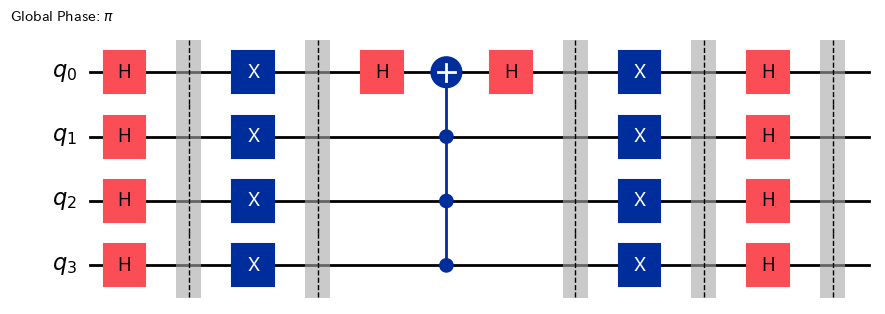


ステップ2完了。振幅増幅のためのディフューザー演算子 U_s が準備完了。


In [24]:
# ステップ 2: マークされた状態の振幅を増幅するためのディフューザーを定義
print("ステップ2: ディフューザー演算子 U_s の準備...")

def build_diffuser_circuit_original(num_qubits):
    """
    Groverのディフューザー演算子 U_s = 2|s><s| - I を実装する量子回路を構築する。
    ここで |s> は均一な重ね合わせ状態。
    """
    diffuser_qc = QuantumCircuit(num_qubits, name="U_s (Diffuser)")
    
    if num_qubits == 1:
        # 1量子ビットの場合、U_s はXゲートと(グローバル位相を除き)等価: 2|+><+| - I = X
        diffuser_qc.x(0)
    else:
        # U_s = H^{⊗n} (2|0><0|^{⊗n} - I) H^{⊗n} の構造を利用。
        # 2|0><0|^{⊗n} - I は、|0...0>状態の位相のみを反転させる操作。
        # これは、Xゲート、(n-1)制御Zゲート、Xゲートのシーケンスで実現できる。
        
        diffuser_qc.h(range(num_qubits)) # 全量子ビットにアダマールゲート
        diffuser_qc.barrier()

        diffuser_qc.x(range(num_qubits)) # 全量子ビットにXゲート
        diffuser_qc.barrier()
        
        # (n-1)制御Zゲート (ターゲットをq_0とし、他を制御ビットとする)
        # Qiskitのmcx (multi-controlled X) をHゲートで挟むことで実現 HXH=Z(XゲートをHゲートで挟むと、Zゲートと等価になる)
        diffuser_qc.h(0) # ターゲット量子ビット(q_0)にH
        diffuser_qc.mcx(list(range(1, num_qubits)), 0) # q_1, ..., q_{n-1} を制御、q_0 をターゲット
        diffuser_qc.h(0) # ターゲット量子ビット(q_0)にH
        diffuser_qc.barrier()
        
        diffuser_qc.x(range(num_qubits)) # 全量子ビットにXゲート
        diffuser_qc.barrier()

        diffuser_qc.h(range(num_qubits)) # 全量子ビットにアダマールゲート
        diffuser_qc.barrier()
        
        # 上記の H(X(MCZ)X)H は I - 2|s><s| を実装するが、2|s><s| - I を得るためには、これに全体として-1を乗じる必要がある。
        # これはグローバル位相πの追加によって達成される (e^{iπ} = -1)。
        diffuser_qc.global_phase += np.pi
        
    return diffuser_qc

print(f"ディフューザー演算子 U_s を構築する関数 (n={n}量子ビット用) を定義しました。")

# n=4量子ビット用のディフューザー回路の構造例を表示。
diffuser_example_n4 = build_diffuser_circuit_original(n)
print("\nディフューザー演算子 U_s の回路図 (例):")
try:
    fig = diffuser_example_n4.draw('mpl', fold=-1)
    if fig: plt.show(); plt.close(fig)
except Exception as e:
    print(f"回路図の'mpl'描画に失敗: {e}. テキスト形式で表示します。")
    print(diffuser_example_n4.draw(output='text', fold=-1))

print("\nステップ2完了。振幅増幅のためのディフューザー演算子 U_s が準備完了。")

ディフューザー演算子 $U_s$ の準備が整った。
この演算子と前述のオラクル $U_f$を組み合わせることで、Groverのアルゴリズムの中核をなす反復操作が構成される。

## 6. ステップ3: Groverの反復 — オラクルとディフューザー
Groverのアルゴリズムにおける振幅増幅は、オラクル演算子 $U_f$ とディフューザー演算子 $U_s$を連続して適用する一連の操作$G=U_f U_s$ を繰り返すことによって達成される。

各反復のプロセスは以下の通りである：

- オラクル $U_f$：マークされた状態の位相を選択的に反転させる。
- ディフューザー $U_s$：全状態の振幅をその平均値周りに反転させ、結果として（位相が反転していた）マークされた状態の振幅を増幅させる。
この $G=U_f U_s$という一連の操作を1つのブロックとして、量子状態に繰り返し作用させていく。以下では、このGrover反復オペレータ $G$ を表す量子回路を構築する。

ステップ3: Grover反復オペレータ G = U_s U_f の準備...
Grover反復回路にオラクル演算子 U_f を追加しました。
Grover反復回路にディフューザー演算子 U_s を追加しました。

Grover反復オペレータ G = U_f U_s の回路図:


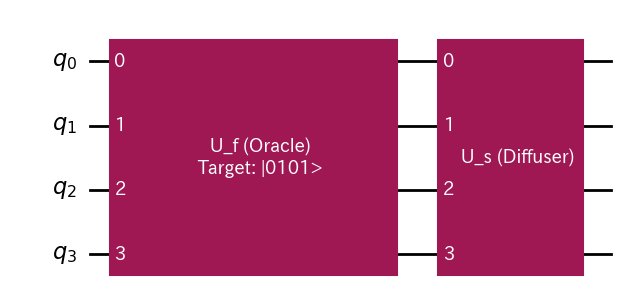


ステップ3完了。Grover反復オペレータ G を構成。


In [25]:
# ステップ3: 一回のGrover反復 (G = U_f U_s) を構成する量子回路を作成する。
print("ステップ3: Grover反復オペレータ G = U_s U_f の準備...")

# n量子ビットの新しい量子回路をGrover反復用に定義。
grover_iteration_circuit = QuantumCircuit(n, name="Grover Iteration (G)")

# まず、オラクル U_f を回路に追加。
# (oracle_circuit は既に U_f として定義済み)
grover_iteration_circuit.append(oracle_circuit.to_instruction(), range(n))
print("Grover反復回路にオラクル演算子 U_f を追加しました。")

# 次に、ディフューザー U_s を回路に追加。
# (diffuser_example_n4 は既に U_s として定義済み)
grover_iteration_circuit.append(diffuser_example_n4.to_instruction(), range(n))
print("Grover反復回路にディフューザー演算子 U_s を追加しました。")

print("\nGrover反復オペレータ G = U_f U_s の回路図:")
try:
    fig = grover_iteration_circuit.draw('mpl', fold=-1) # fold=-1で回路構造を詳細に表示
    if fig: plt.show(); plt.close(fig)
except Exception as e:
    print(f"回路図の'mpl'描画に失敗: {e}. テキスト形式で表示します。")
    print(grover_iteration_circuit.draw(output='text', fold=-1))

print("\nステップ3完了。Grover反復オペレータ G を構成。")

これでGrover反復オペレータ $G$ が構成された。
このオペレータを量子状態に作用させることで、振幅増幅のプロセスが進行する。
次のステップでは、このGrover反復オペレータを初期状態に1回適用し、その効果を観察する。

## 7. ステップ4: 最初の増幅効果 - 1回目のGrover反復後の状態
均一な重ね合わせ状態 $\ket{s}$ (これは `init_qc` によって生成される状態) に、構築したGrover反復オペレータ $G$ (`grover_iteration_circuit` に相当) を1回適用する。この操作 $G\ket{s}$ によって、マークされた状態 $\ket{0101}$ の振幅がどのように変化し、その結果として測定確率が増加するかを確認する。

この計算は、`init_qc` の後に `grover_iteration_circuit` を接続 し、得られた全体の回路から状態ベクトルを計算することで行う。

ステップ4: 1回目のGrover反復の適用と評価...
初期化回路に1回のGrover反復を接続しました。
1回反復後の状態ベクトルを計算しました。

1回のGrover反復後、状態 |0101> は:
  実数振幅 ≈ 0.6875 (初期状態から増加)
  測定確率 ≈ 0.4727 (同様に増加)

1回目のGrover反復後の「実数振幅」分布:


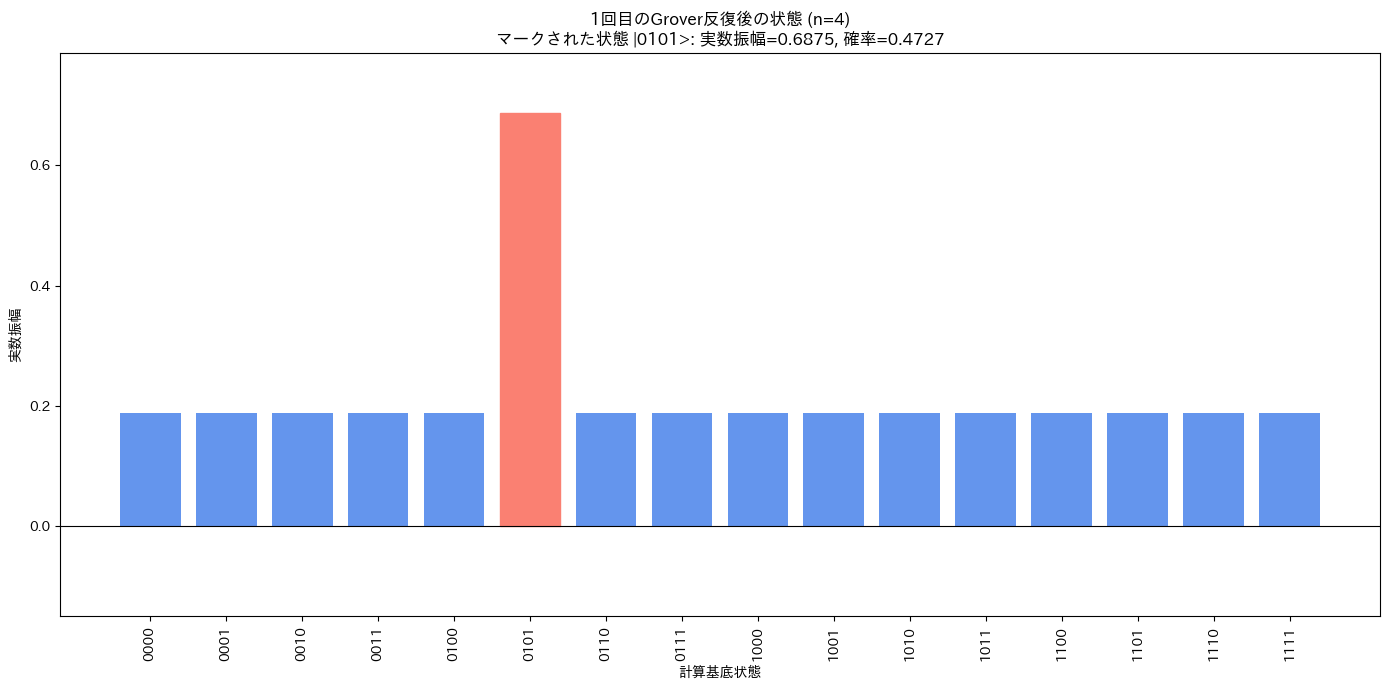


1回目のGrover反復後の「測定確率」分布:


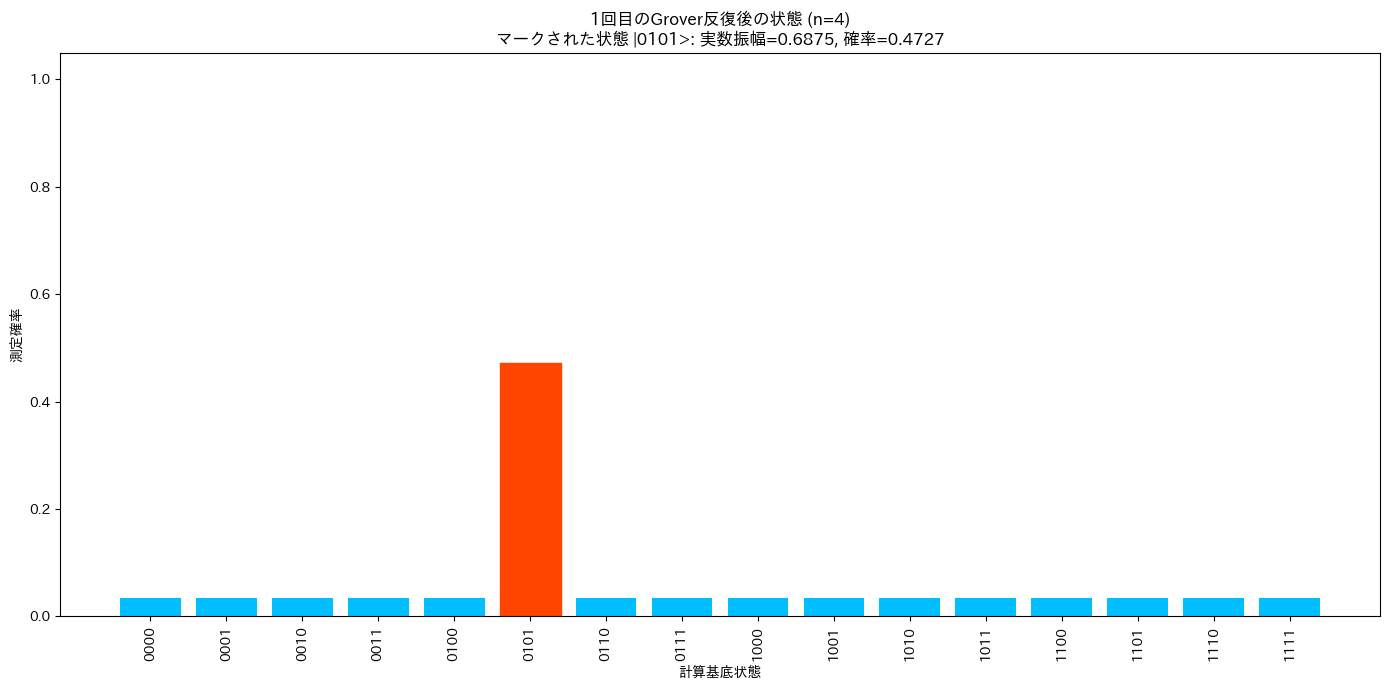


初期化から1回のGrover反復までの全回路図:
まず、分解前の抽象的な回路図を表示します（オラクルやDiffuserがブラックボックスの状態）。


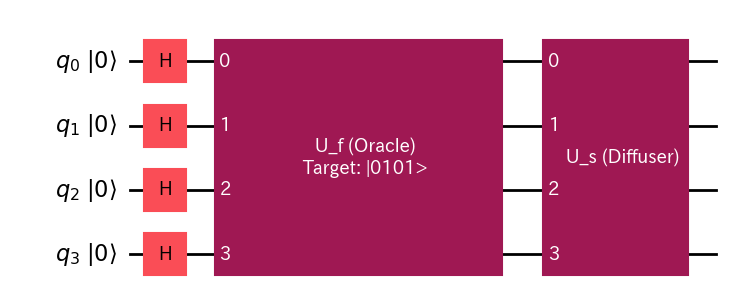


次に、この全回路をUやRzを使わない基本ゲートセットにトランスパイルします...
ターゲットの基本ゲートセット: ['cx', 'x', 'z', 'h', 's', 't', 'rz']

▼ 基本ゲートだけで表現したGrover反復（1回）の全回路図
描画に成功しました。回路が長大であるため、画像が非常に大きくなることがあります。


/usr/local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:267: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /usr/local/lib/python3.10/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


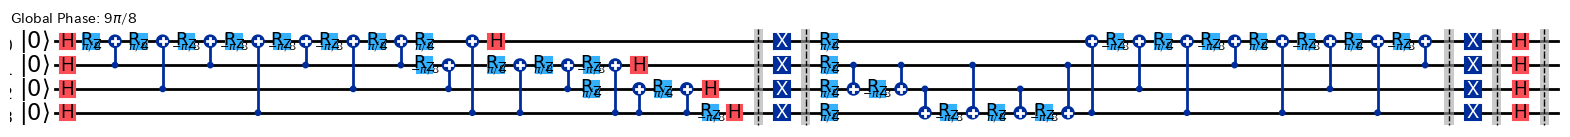


分解後の全回路の深さ: 57
分解後の全回路の総ゲート数: OrderedDict([('rz', 30), ('cx', 28), ('h', 12), ('x', 8), ('barrier', 5)])

ステップ4完了。マークされた状態の振幅と確率が増加。


In [32]:
# ステップ4: 最初のGrover反復を均一重ね合わせ状態に適用し、結果を評価 
print("ステップ4: 1回目のGrover反復の適用と評価...")

# 初期化回路(init_qc)の出力に、Grover反復回路(grover_iteration_circuit)を接続。
# Qiskitの QuantumCircuit.compose() メソッドは、この操作を適切に行う。
qc_after_1_iter = init_qc.compose(grover_iteration_circuit)
qc_after_1_iter.name = "Init + 1 Grover Iteration" # 回路に名前を付ける。
print("初期化回路に1回のGrover反復を接続しました。")

# 1回のGrover反復を適用した後の状態ベクトルを計算。
sv_after_1_iter = Statevector(qc_after_1_iter)
print("1回反復後の状態ベクトルを計算しました。")

# マークされた状態の振幅と確率の変化を評価。
amp_1_iter_real = np.real(sv_after_1_iter.data[marked_item_int])
prob_1_iter_marked = sv_after_1_iter.probabilities_dict().get(marked_item_binary, 0.0)

print(f"\n1回のGrover反復後、状態 |{marked_item_binary}> は:")
print(f"  実数振幅 ≈ {amp_1_iter_real:.4f} (初期状態から増加)")
print(f"  測定確率 ≈ {prob_1_iter_marked:.4f} (同様に増加)")

# 状態の振幅と確率をプロットして視覚的に確認。
print("\n1回目のGrover反復後の「実数振幅」分布:")
plot_state_real_amplitudes(
    sv_after_1_iter,
    f"1回目のGrover反復後の状態 (n={n})",
    marked_label=marked_item_binary,
    marked_amplitude_val=amp_1_iter_real,
    marked_prob_val=prob_1_iter_marked
)

print("\n1回目のGrover反復後の「測定確率」分布:")
plot_state_probabilities(
    sv_after_1_iter,
    f"1回目のGrover反復後の状態 (n={n})",
    marked_label=marked_item_binary,
    marked_amplitude_val=amp_1_iter_real,
    marked_prob_val=prob_1_iter_marked
)

print("\n初期化から1回のGrover反復までの全回路図:")
print("まず、分解前の抽象的な回路図を表示します（オラクルやDiffuserがブラックボックスの状態）。")
try:
    # initial_state=True は |0> からの開始を示すのに便利
    fig = qc_after_1_iter.draw('mpl', initial_state=True, fold=-1)
    if fig:
        plt.show()
        plt.close(fig)
except Exception as e:
    print(f"回路図の'mpl'描画に失敗: {e}.")
    print(qc_after_1_iter.draw('text', fold=-1))


print("\n次に、この全回路をUやRzを使わない基本ゲートセットにトランスパイルします...")

# ターゲットとする基本ゲートのリスト
basis_gates = ['cx', 'x', 'z', 'h', 's', 't', 'rz']
print(f"ターゲットの基本ゲートセット: {basis_gates}")

# トランスパイルを実行
# 最適化レベル1で、基本ゲートへの分解を行います
transpiled_full_circuit = transpile(
    qc_after_1_iter,
    basis_gates=basis_gates,
    optimization_level=3
)

print("\n▼ 基本ゲートだけで表現したGrover反復（1回）の全回路図")
try:
    # initial_state=True, foldで折り返し、styleで見栄えを調整
    fig = transpiled_full_circuit.draw('mpl', initial_state=True, fold=150, style='iqx')
    if fig:
        print("描画に成功しました。回路が長大であるため、画像が非常に大きくなることがあります。")
        # 表示する画像のサイズを調整
        fig.set_size_inches(20, 12)
        display(fig) # Jupyter環境では display() が推奨されます
        plt.close(fig) # メモリを解放
except Exception as e:
    print(f"トランスパイル後の回路図の'mpl'描画に失敗しました: {e}.")


# 最終的な回路の複雑さを数値で確認
print(f"\n分解後の全回路の深さ: {transpiled_full_circuit.depth()}")
print(f"分解後の全回路の総ゲート数: {transpiled_full_circuit.count_ops()}")


print("\nステップ4完了。マークされた状態の振幅と確率が増加。")

プロットから明らかなように、1回のGrover反復を適用するだけで、マークされた状態 $\ket{0101}$ の実数振幅は顕著に増加し、測定確率も他の状態に比べて高くなった。これが振幅増幅の効果である。

しかし、Groverのアルゴリズムの真価は、この反復を最適な回数だけ行うことで発揮される。
次に、その最適な反復回数について述べる。

## 8. ステップ5: 最適な反復回数の決定

Groverのアルゴリズムにおいて、マークされたアイテムを発見する確率を最大化するためには、Grover反復 $G=U_f U_s$ を適切な回数だけ実行することが不可欠である。反復回数が不足していると振幅増幅が不十分となり、逆に反復回数が過剰になると、マークされた状態の振幅が減少し、測定確率が低下してしまう。

探索空間の全アイテム数を $N$、マークされたアイテムの数を $M$ とした場合、最適な反復回数 $k $は以下の近似式で与えられる。
​$$ k ≈ \frac{\pi}{4} \sqrt{\frac{N}{M}}$$

詳細は以下サイトを参照。
Quantum Native Dojo! https://dojo.qulacs.org/ja/latest/notebooks/8.2_Grovers_algorithm.html

この式は、Groverのアルゴリズムの幾何学的解釈（状態ベクトルが2次元平面内で回転する）から導出される。この回転の角度が $\frac{\pi}{2}$に最も近くなるように反復回数を選ぶのが最適である。
今回のケースでは、$N=16$（$2^4$状態)、$M=1$（探索対象は1つ）のため、この値を基に最適な反復回数を計算する。

In [36]:
# ステップ5: Grover反復の最適な回数を計算
print("ステップ5: 最適反復回数の計算...")

M = 1 # マークされたアイテムの数。今回は1つ。

# 最適反復回数の理論式に基づいて計算。
optimal_iters_float = (np.pi / 4.0) * np.sqrt(N / M)
# 反復回数は整数である必要があるため、計算結果に最も近い整数（ここでは床関数 floor を使用）を選ぶ。
optimal_iters = int(np.floor(optimal_iters_float))

print(f"全状態数 (N): {N}")
print(f"マークされたアイテム数 (M): {M}")
print(f"計算された最適反復回数 (浮動小数点数): {optimal_iters_float:.4f}")
print(f"適用する整数としての最適反復回数 (R_opt): {optimal_iters}")

print("\nステップ5完了。最適な反復回数が決定。")

ステップ5: 最適反復回数の計算...
全状態数 (N): 16
マークされたアイテム数 (M): 1
計算された最適反復回数 (浮動小数点数): 3.1416
適用する整数としての最適反復回数 (R_opt): 3

ステップ5完了。最適な反復回数が決定。


計算の結果、$N=16,M=1$ の場合、最適なGrover反復回数はおよそ3回であることが示された。これは、Groverオペレータを3回適用することで、マークされた状態 $\ket{0101}$ を測定する確率が最大になることを示唆している。
次のステップでは、この最適回数の反復を実際に適用し、回数が適切かを検証する。また、比較のために2回目の反復後の状態も確認し、その後、最適回数を超えた場合の現象についても観察する。

## 9. ステップ6: 反復の進行 - 2回目のGrover反復後の状態
最適反復回数が3回であると予測されたため、その途中の段階として、2回目のGrover反復 $G^2\ket{s}$ を適用した後の状態を調べてみる。
1回目の反復で既に確認された振幅増幅の効果が、この2回目の反復によってさらに進展することが期待される。マークされた状態 $\ket{0101}$ の振幅と確率が、1回目の反復後からどのように変化するかに注目する。

ステップ6: 2回目のGrover反復の適用と評価...
初期化回路に2回のGrover反復を接続しました。
2回反復後の状態ベクトルを計算しました。

2回のGrover反復後、状態 |0101> は:
  実数振幅 ≈ 0.9531
  測定確率 ≈ 0.9084

2回目のGrover反復後の「実数振幅」分布:


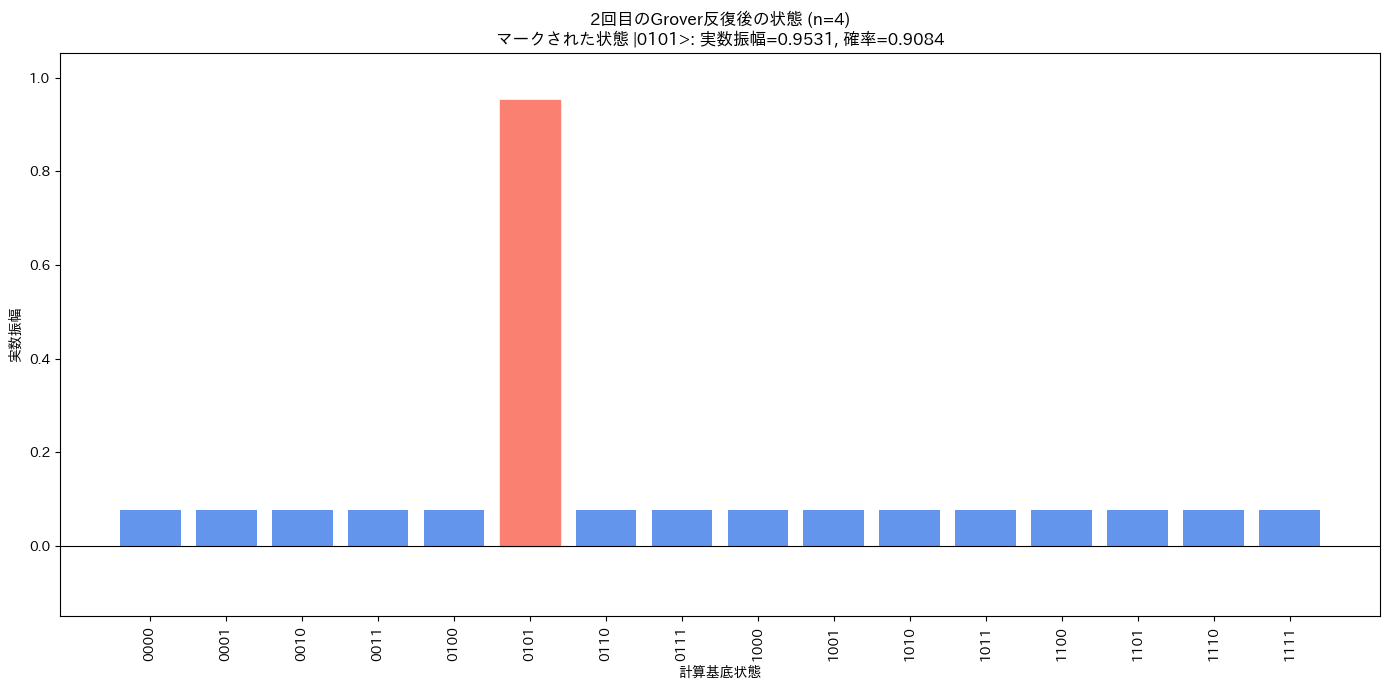


2回目のGrover反復後の「測定確率」分布:


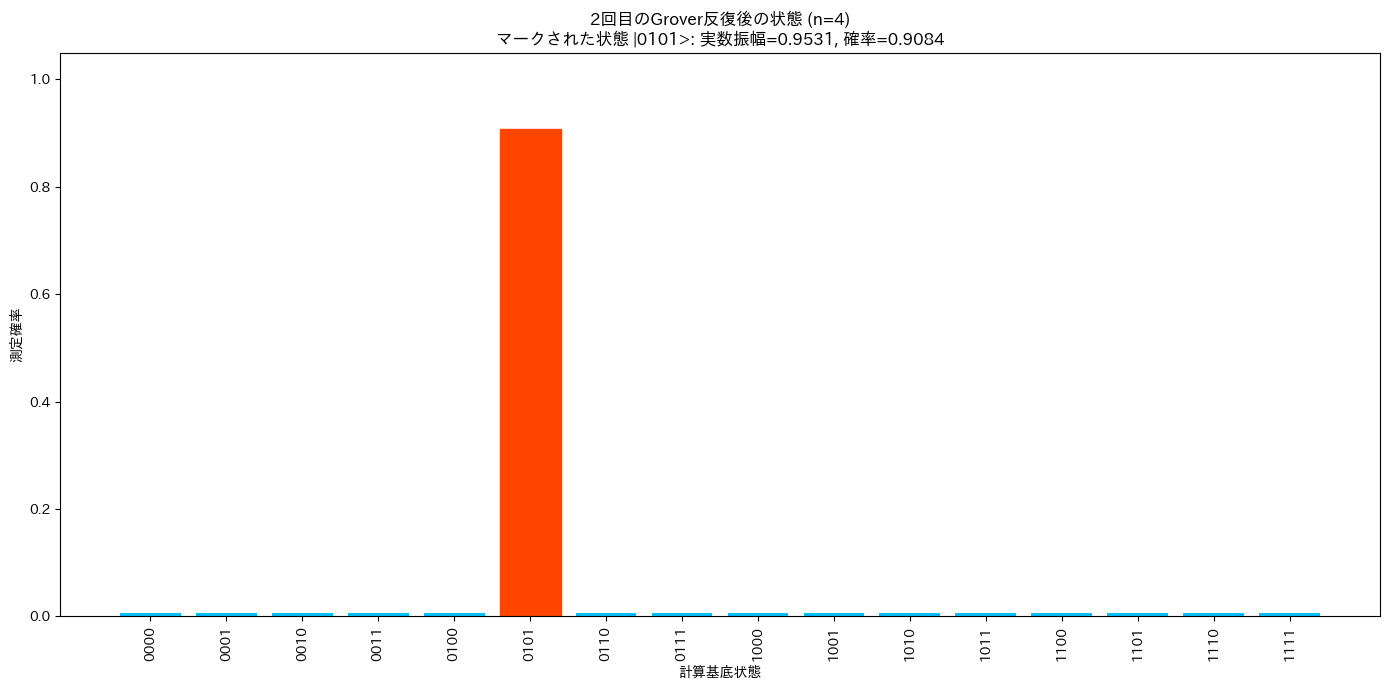


初期化から2回のGrover反復までの全回路図:


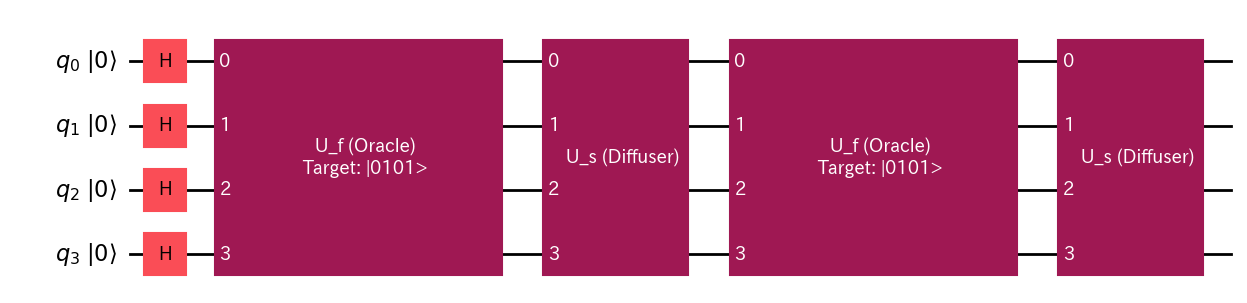


ステップ6完了。マークされた状態の振幅と確率がさらに増加。


In [37]:
# ステップ6: 2回目のGrover反復を適用し、状態を評価
# (このステップは、計算された最適反復回数が2以上の場合に意味を持つ)

print("ステップ6: 2回目のGrover反復の適用と評価...")

if optimal_iters >= 2:
    # 初期化回路(init_qc)から開始し、Grover反復回路(grover_iteration_circuit)を2回適用。
    qc_after_2_iters = init_qc.copy()
    qc_after_2_iters.name = "Init + 2 Grover Iterations"
    for _ in range(2): # 2回反復
        qc_after_2_iters = qc_after_2_iters.compose(grover_iteration_circuit)
    print("初期化回路に2回のGrover反復を接続しました。")

    # 2回反復適用後の状態ベクトルを計算。
    sv_after_2_iters = Statevector(qc_after_2_iters)
    print("2回反復後の状態ベクトルを計算しました。")

    # マークされた状態の振幅と確率を評価。
    amp_2_iters_real = np.real(sv_after_2_iters.data[marked_item_int])
    prob_2_iters_marked = sv_after_2_iters.probabilities_dict().get(marked_item_binary, 0.0)

    print(f"\n2回のGrover反復後、状態 |{marked_item_binary}> は:")
    print(f"  実数振幅 ≈ {amp_2_iters_real:.4f}")
    print(f"  測定確率 ≈ {prob_2_iters_marked:.4f}")

    # 状態の振幅と確率をプロット。
    print("\n2回目のGrover反復後の「実数振幅」分布:")
    plot_state_real_amplitudes(
        sv_after_2_iters,
        f"2回目のGrover反復後の状態 (n={n})",
        marked_label=marked_item_binary,
        marked_amplitude_val=amp_2_iters_real,
        marked_prob_val=prob_2_iters_marked
    )

    print("\n2回目のGrover反復後の「測定確率」分布:")
    plot_state_probabilities(
        sv_after_2_iters,
        f"2回目のGrover反復後の状態 (n={n})",
        marked_label=marked_item_binary,
        marked_amplitude_val=amp_2_iters_real,
        marked_prob_val=prob_2_iters_marked
    )

    print("\n初期化から2回のGrover反復までの全回路図:")
    try:
        fig = qc_after_2_iters.draw('mpl', initial_state=True, fold=-1)
        if fig: plt.show(); plt.close(fig)
    except Exception as e:
        print(f"回路図の'mpl'描画に失敗: {e}. テキスト形式で表示します。")
        print(qc_after_2_iters.draw(output='text', fold=-1))
    
    print("\nステップ6完了。マークされた状態の振幅と確率がさらに増加。")
else:
    print("最適反復回数が2未満のため、2回目の反復のシミュレーションはスキップ。")

2回のGrover反復後、マークされた状態 $\ket{0101}$ の振幅と確率は、1回目の反復後よりもさらに増大していることが確認できた。
これは振幅増幅プロセスが順調に進行していることを示している。

## 10. ステップ7: 最適反復回数後の状態

ステップ5で計算した最適反復回数（$k$ ≈ 3回）だけGroverオペレータを適用した後の量子状態 $G^k \ket{s}$を調べる。理論的には、この時点でマークされた状態 $\ket{0101}$を測定する確率が最大（またはそれに非常に近い値）に達しているはずである。
この状態が、Groverのアルゴリズムが目指す最終的な増幅された状態である。

ステップ7: 最適回数 (3回) のGrover反復の適用と評価...
初期化回路に3回のGrover反復を接続しました。
最適回数反復後の状態ベクトルを計算しました。

3回 (最適回数) のGrover反復後、状態 |0101> は:
  実数振幅 ≈ 0.9805 (ほぼ最大値に達した)
  測定確率 ≈ 0.9613 (同様にほぼ最大値)

3回 (最適回数) のGrover反復後の「実数振幅」分布:


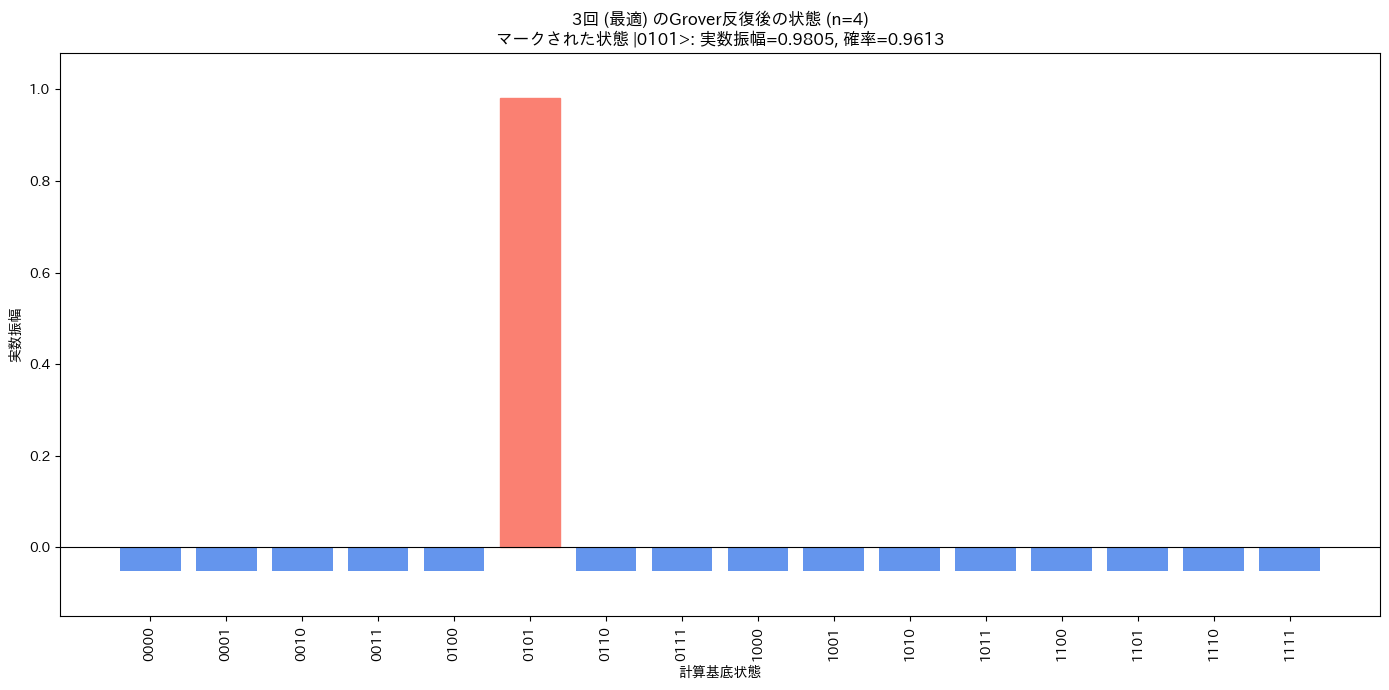


3回 (最適回数) のGrover反復後の「測定確率」分布:


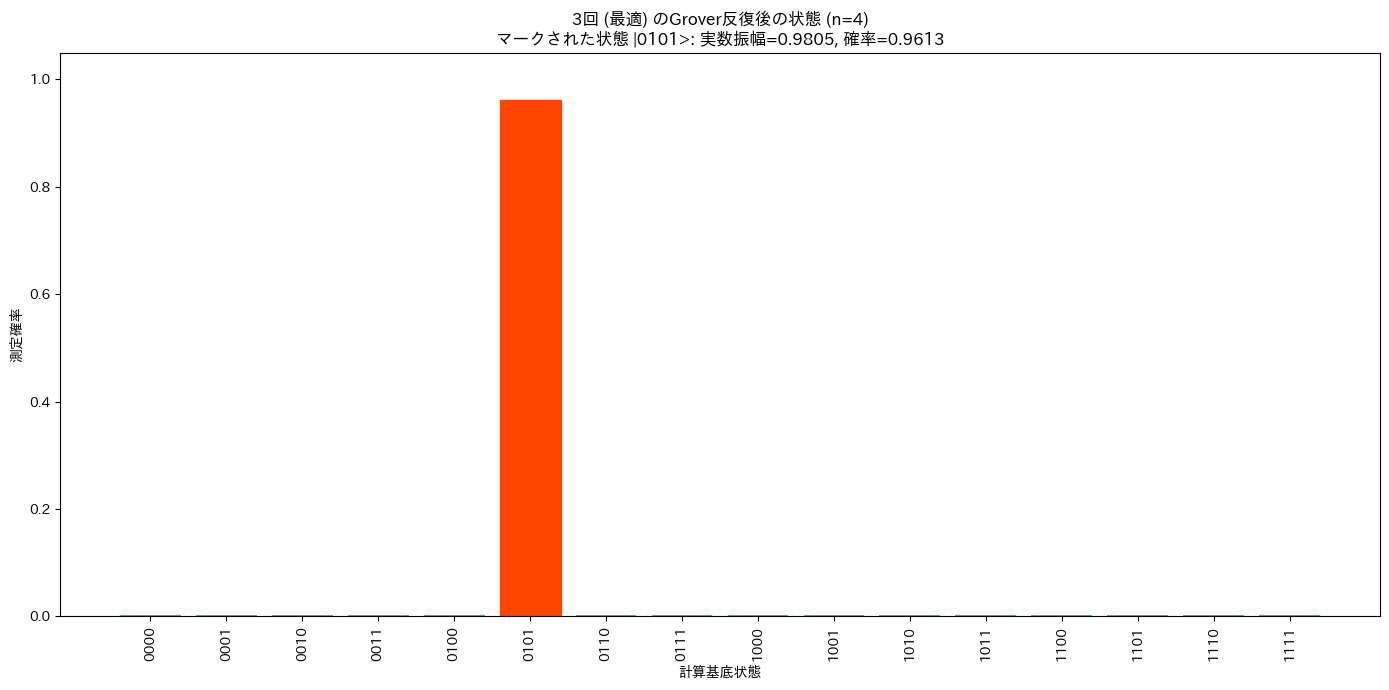


初期化から3回 (最適回数) のGrover反復までの全回路図:


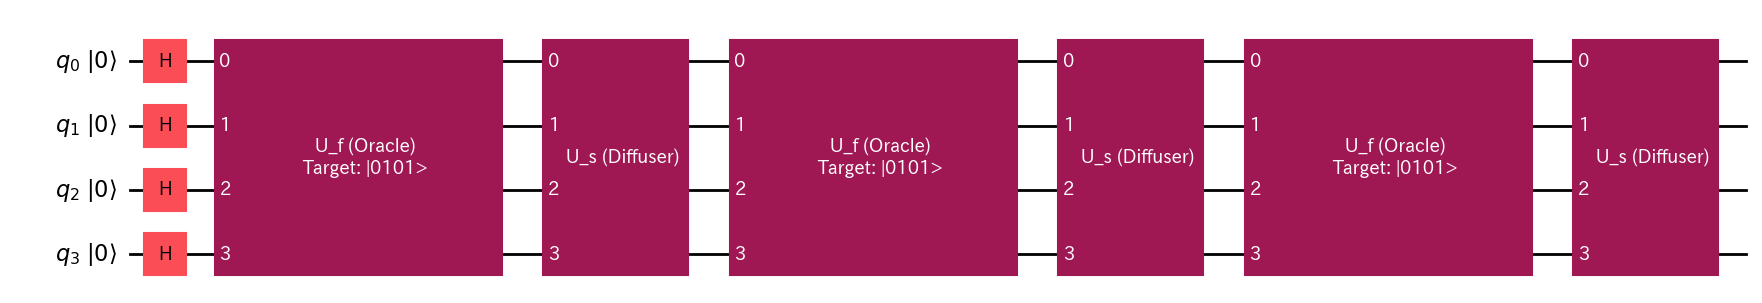


ステップ7完了。マークされた状態の確率が最大近くまで増幅された。


In [38]:
# ステップ7: 最適回数のGrover反復を適用し、状態を評価
print(f"ステップ7: 最適回数 ({optimal_iters}回) のGrover反復の適用と評価...")

# 初期化回路(init_qc)から開始し、Grover反復回路(grover_iteration_circuit)を最適回数適用。
qc_optimal_iters = init_qc.copy()
qc_optimal_iters.name = f"Init + {optimal_iters} (Optimal) Grover Iterations"
for _ in range(optimal_iters):
    qc_optimal_iters = qc_optimal_iters.compose(grover_iteration_circuit)
print(f"初期化回路に{optimal_iters}回のGrover反復を接続しました。")

# 最適回数反復適用後の状態ベクトルを計算。
sv_after_optimal = Statevector(qc_optimal_iters)
print("最適回数反復後の状態ベクトルを計算しました。")

# マークされた状態の振幅と確率を評価。
amp_optimal_real = np.real(sv_after_optimal.data[marked_item_int])
prob_optimal_marked = sv_after_optimal.probabilities_dict().get(marked_item_binary, 0.0)

print(f"\n{optimal_iters}回 (最適回数) のGrover反復後、状態 |{marked_item_binary}> は:")
print(f"  実数振幅 ≈ {amp_optimal_real:.4f} (ほぼ最大値に達した)")
print(f"  測定確率 ≈ {prob_optimal_marked:.4f} (同様にほぼ最大値)")

# 状態の振幅と確率をプロット。
print(f"\n{optimal_iters}回 (最適回数) のGrover反復後の「実数振幅」分布:")
plot_state_real_amplitudes(
    sv_after_optimal,
    f"{optimal_iters}回 (最適) のGrover反復後の状態 (n={n})",
    marked_label=marked_item_binary,
    marked_amplitude_val=amp_optimal_real,
    marked_prob_val=prob_optimal_marked
)

print(f"\n{optimal_iters}回 (最適回数) のGrover反復後の「測定確率」分布:")
plot_state_probabilities(
    sv_after_optimal,
    f"{optimal_iters}回 (最適) のGrover反復後の状態 (n={n})",
    marked_label=marked_item_binary,
    marked_amplitude_val=amp_optimal_real,
    marked_prob_val=prob_optimal_marked
)

print(f"\n初期化から{optimal_iters}回 (最適回数) のGrover反復までの全回路図:")
try:
    # 回路が深くなるため、fold値を調整して描画を試みる。
    fold_value = 100 if qc_optimal_iters.depth() < 200 else 50 
    fig = qc_optimal_iters.draw('mpl', initial_state=True, fold=fold_value)
    if fig: plt.show(); plt.close(fig)
except Exception as e:
    print(f"回路図の'mpl'描画に失敗: {e}. 回路深度: {qc_optimal_iters.depth()}. テキスト形式で表示します。")
    print(qc_optimal_iters.draw(output='text', fold=150)) # fold値を調整してテキスト表示

print(f"\nステップ7完了。マークされた状態の確率が最大近くまで増幅された。")

最適回数である3回の反復後、マークされた状態 $\ket{0101}$ の測定確率は非常に高くなっていることがプロットから確認できた。
ほぼ確実にマークされたアイテムを見つけられる状態となった。

# 11. 最適反復回数を超えた場合
Groverのアルゴリズムにおいて、反復回数は非常に重要である。
最適回数を超えて反復を続けると、マークされた状態の振幅は最大値から減少し始め、他の状態の振幅が相対的に増加するという「過増幅」と呼ばれる現象が発生する。これは、Grover反復が状態ベクトルをある軸周りに回転させる操作であると解釈した場合、回転が行き過ぎてしまうことに対応している。

ここでは、最適反復回数（3回）を少し超えた、例えば4回の反復を行った場合に、マークされた状態の確率がどのように変化するかを観察し、この現象を理解する。

4回 (最適回数超え) のGrover反復の適用と評価 ...
初期化回路に4回のGrover反復を接続しました。
4回反復後の状態ベクトルを計算しました。

4回 (最適回数超え) のGrover反復後、状態 |0101> は:
  実数振幅 ≈ 0.7627 (最適時より減少した)
  測定確率 ≈ 0.5817 (同様に減少した)

4回 (最適回数超え) のGrover反復後の「実数振幅」分布:


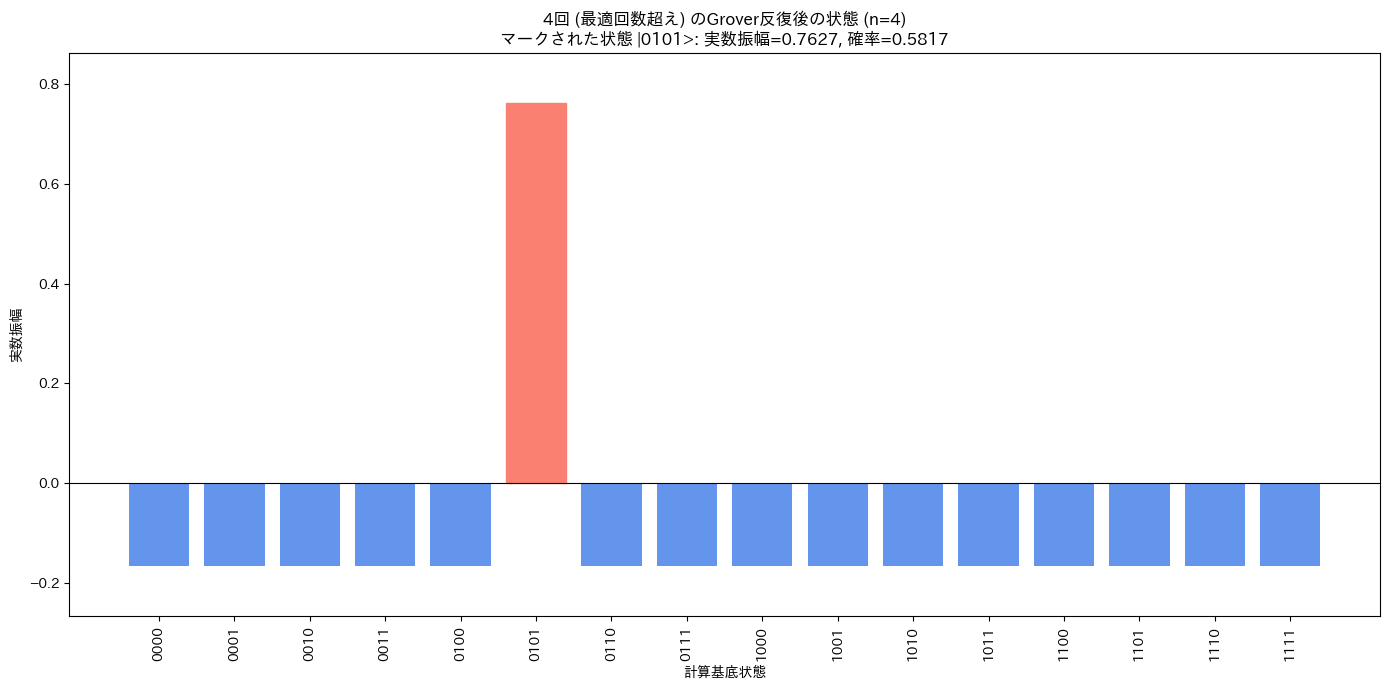


4回 (最適回数超え) のGrover反復後の「測定確率」分布:


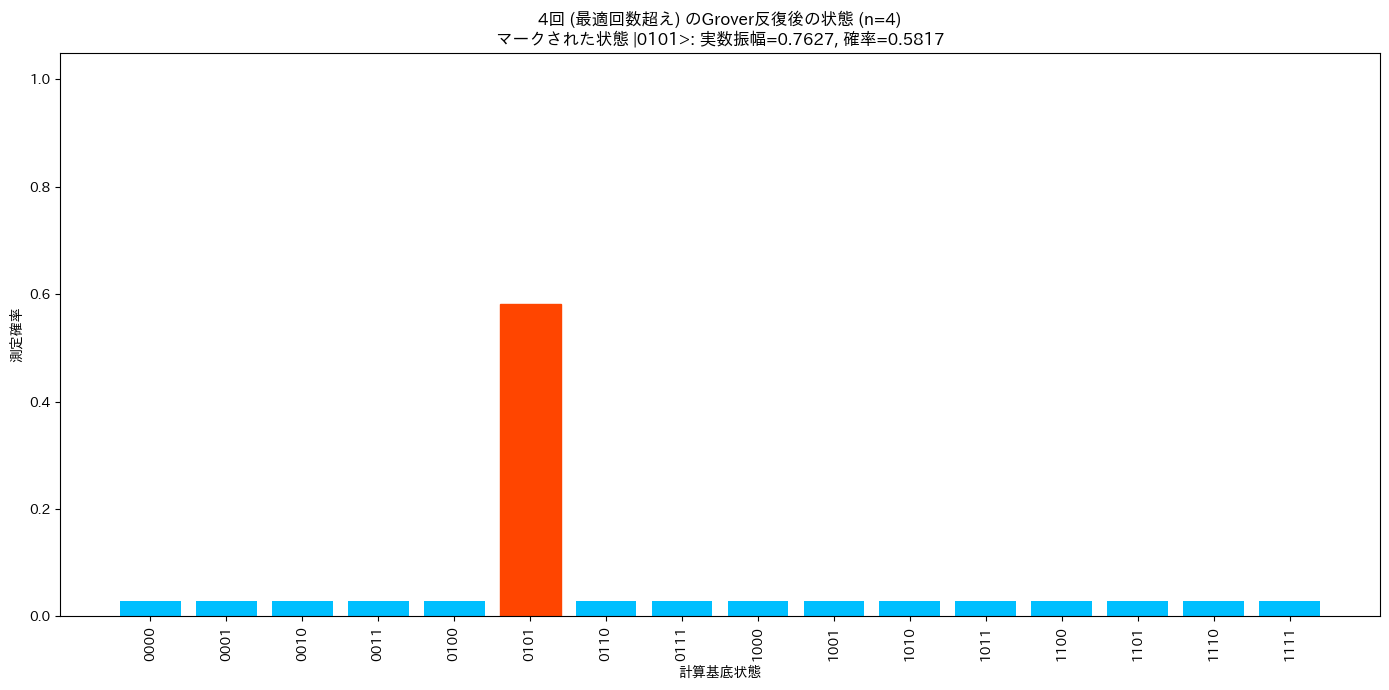


最適反復回数を超えると、マークされた状態の確率が低下する現象が確認できた。


In [40]:
# 最適反復回数を超えてGrover反復を適用し、「過振幅」現象を観察する
num_extra_iters = optimal_iters + 1 # 最適回数より1回多い反復回数を設定
print(f"{num_extra_iters}回 (最適回数超え) のGrover反復の適用と評価 ...")

# 初期化回路(init_qc)から開始し、Grover反復回路(grover_iteration_circuit)を num_extra_iters 回適用。
qc_after_extra_iters = init_qc.copy()
qc_after_extra_iters.name = f"Init + {num_extra_iters} (Overcooked) Grover Iterations"
for _ in range(num_extra_iters):
    qc_after_extra_iters = qc_after_extra_iters.compose(grover_iteration_circuit)
print(f"初期化回路に{num_extra_iters}回のGrover反復を接続しました。")

# 反復適用後の状態ベクトルを計算。
sv_after_extra_iters = Statevector(qc_after_extra_iters)
print(f"{num_extra_iters}回反復後の状態ベクトルを計算しました。")

# マークされた状態の振幅と確率を評価。
amp_extra_iters_real = np.real(sv_after_extra_iters.data[marked_item_int])
prob_extra_iters_marked = sv_after_extra_iters.probabilities_dict().get(marked_item_binary, 0.0)

print(f"\n{num_extra_iters}回 (最適回数超え) のGrover反復後、状態 |{marked_item_binary}> は:")
print(f"  実数振幅 ≈ {amp_extra_iters_real:.4f} (最適時より減少した)")
print(f"  測定確率 ≈ {prob_extra_iters_marked:.4f} (同様に減少した)")

# 状態の振幅と確率をプロット。
print(f"\n{num_extra_iters}回 (最適回数超え) のGrover反復後の「実数振幅」分布:")
plot_state_real_amplitudes(
    sv_after_extra_iters,
    f"{num_extra_iters}回 (最適回数超え) のGrover反復後の状態 (n={n})",
    marked_label=marked_item_binary,
    marked_amplitude_val=amp_extra_iters_real,
    marked_prob_val=prob_extra_iters_marked
)

print(f"\n{num_extra_iters}回 (最適回数超え) のGrover反復後の「測定確率」分布:")
plot_state_probabilities(
    sv_after_extra_iters,
    f"{num_extra_iters}回 (最適回数超え) のGrover反復後の状態 (n={n})",
    marked_label=marked_item_binary,
    marked_amplitude_val=amp_extra_iters_real,
    marked_prob_val=prob_extra_iters_marked
)

print(f"\n最適反復回数を超えると、マークされた状態の確率が低下する現象が確認できた。")

プロットが示すように、最適反復回数である3回を超えて4回目の反復を行うと、マークされた状態 $\ket{0101}$ の測定確率は、3回反復時のピーク値から実際に低下している。これは、Groverのアルゴリズムを効果的に使用するためには、適切な反復回数を見積もることが極めて重要であることを示している。

# 12. 全体像の確認：Groverアルゴリズムの完全な量子回路図
これまでのステップを統合し、初期化から最適回数のGrover反復、そして最終的な測定までを含む、Groverのアルゴリズム全体の量子回路図を以下に示す。※回路の深さ（実行されるゲートの層の数）は、量子ビット数や反復回数と共に増加することに注意。

全体回路図の作成 (最適 3 反復)...
Groverアルゴリズムの全体回路 (最適 3 反復、測定あり) の構成図:


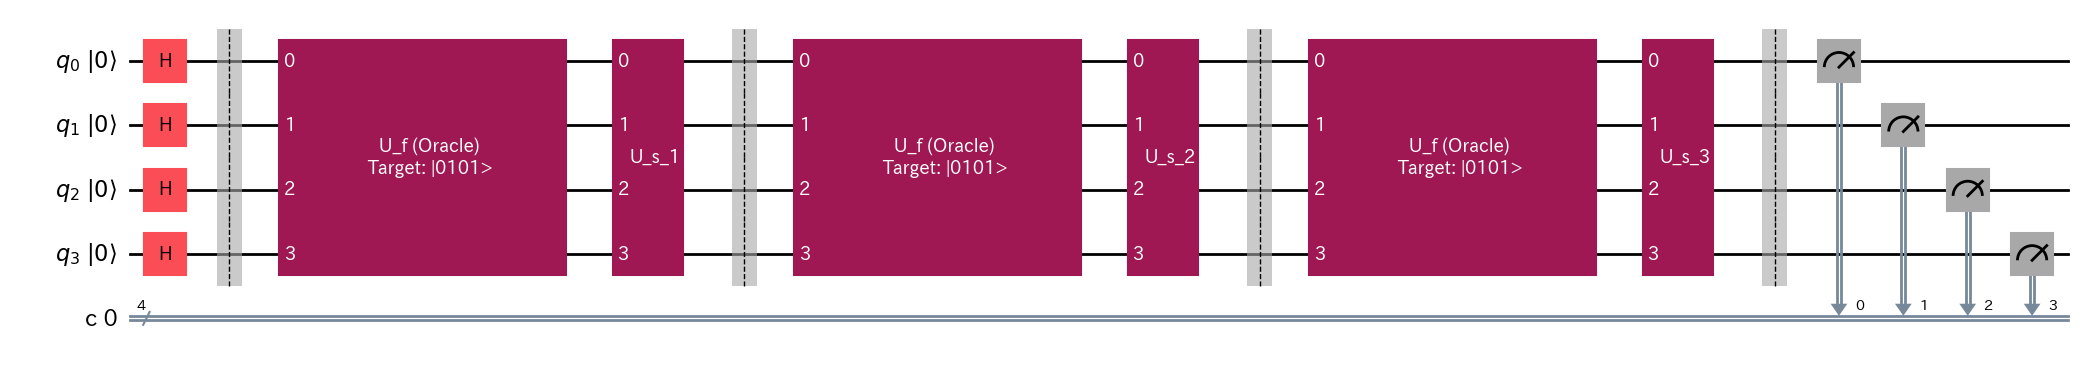


アルゴリズム全体の設計図が確認できた。


In [42]:
# 最適回数の反復を含むGroverアルゴリズム全体の量子回路図を作成・表示する
print(f"全体回路図の作成 (最適 {optimal_iters} 反復)...")

# n量子ビット入力、n古典ビット出力の量子回路を定義（測定結果を格納するため）。
full_grover_qc_draw = QuantumCircuit(n, n, name=f"Grover Algorithm (n={n}, R={optimal_iters})")

# 1. 初期化: 全量子ビットにアダマールゲートを適用
full_grover_qc_draw.h(range(n))
full_grover_qc_draw.barrier() # 回路の可読性のためにバリアを挿入

# 2. Grover反復: 最適回数だけ実行
#    各反復はオラクル(U_f)とディフューザー(U_s)から構成。
#    grover_iteration_circuit は既に G = U_f U_s として定義。
num_display_iters = max(1, optimal_iters) # 0回反復でも回路図上は何らかの構造を見せるため

for i in range(num_display_iters):
    # G = U_f U_s を追加。個別のU_f, U_sを見せるため再構成も可だが、ここではGをブロックとして扱う。
    # 詳細な構成を見せるため、oracle_circuit と diffuser_example_n4 を直接appendする形も考えられる。
    # 元のスクリプトの意図を汲み、個別の構成要素を見せるようにする。
    full_grover_qc_draw.append(oracle_circuit.to_instruction(), range(n))
    current_diffuser = build_diffuser_circuit_original(n) # 各反復で新しいインスタンス
    current_diffuser.name = f"U_s_{i+1}"
    full_grover_qc_draw.append(current_diffuser.to_instruction(), range(n))
    
    if i < num_display_iters - 1 : # 最後の反復の後にはバリアは不要
        full_grover_qc_draw.barrier()

full_grover_qc_draw.barrier()

# 3. 測定: 全量子ビットを測定し、結果を古典ビットに格納
full_grover_qc_draw.measure(range(n), range(n))

print(f"Groverアルゴリズムの全体回路 (最適 {optimal_iters} 反復、測定あり) の構成図:")
try:
    # 回路の深さに応じて fold パラメータを調整
    fold_value = 100 if full_grover_qc_draw.depth() < 250 else 60
    fig = full_grover_qc_draw.draw('mpl', fold=fold_value, initial_state=True)
    if fig:
        plt.show()
        plt.close(fig)
except Exception as e:
    print(f"回路図の'mpl'描画に失敗: {e}. 回路深度: {full_grover_qc_draw.depth()}.")
    print("テキスト形式での回路図を表示し、ファイルにも保存します。")
    if not os.path.exists(plots_dir): # 保存先ディレクトリがなければ作成
        os.makedirs(plots_dir)
    text_circuit_path = os.path.join(plots_dir, f"full_grover_circuit_n{n}_R{optimal_iters}.txt")
    try:
        circuit_text_representation = str(full_grover_qc_draw.draw(output='text', fold=-1)) # fold=-1で全体表示
        print("\nテキスト形式の回路図:")
        print(circuit_text_representation)
        with open(text_circuit_path, 'w', encoding='utf-8') as f:
            f.write(circuit_text_representation)
        print(f"テキスト形式の回路図を '{text_circuit_path}' に保存しました。")
    except Exception as e_text:
        print(f"テキスト形式の回路図の表示/保存にも失敗: {e_text}")

print(f"\nアルゴリズム全体の設計図が確認できた。")

これで、Groverのアルゴリズムを実行するための完全な量子回路が定義された。
最終ステップは、この回路を実行し、測定結果を分析することである。

## 13. 最終ステップ：測定と結果の分析
Groverのアルゴリズムの最終段階は、増幅された量子状態を測定することである。
量子測定を行うと、量子ビットの重ね合わせ状態は収縮し、特定の計算基底状態（例えば $\ket{0101}$）が古典的なビット列として得られる。
ある状態が測定される確率は、その状態の振幅の絶対値の2乗に比例する。

今回は、Groverのアルゴリズムによってマークされた状態の振幅が大幅に増幅されたため、この状態が高い確率で測定されることが期待される。

実際の量子コンピュータでは測定は確率的に振る舞うため、通常、同じ回路を多数回実行（「ショット」を繰り返す）し、測定結果の統計分布（ヒストグラム）を得る。ここではシミュレータを用い、多数のショットを実行して、マークされた状態 $\ket{0101}$ が実際に高い頻度で観測されるかを確認する。

測定と結果の分析 (最適 3 反復後)...

2048回のショットによる測定結果 (カウント数):

測定結果のヒストグラム:


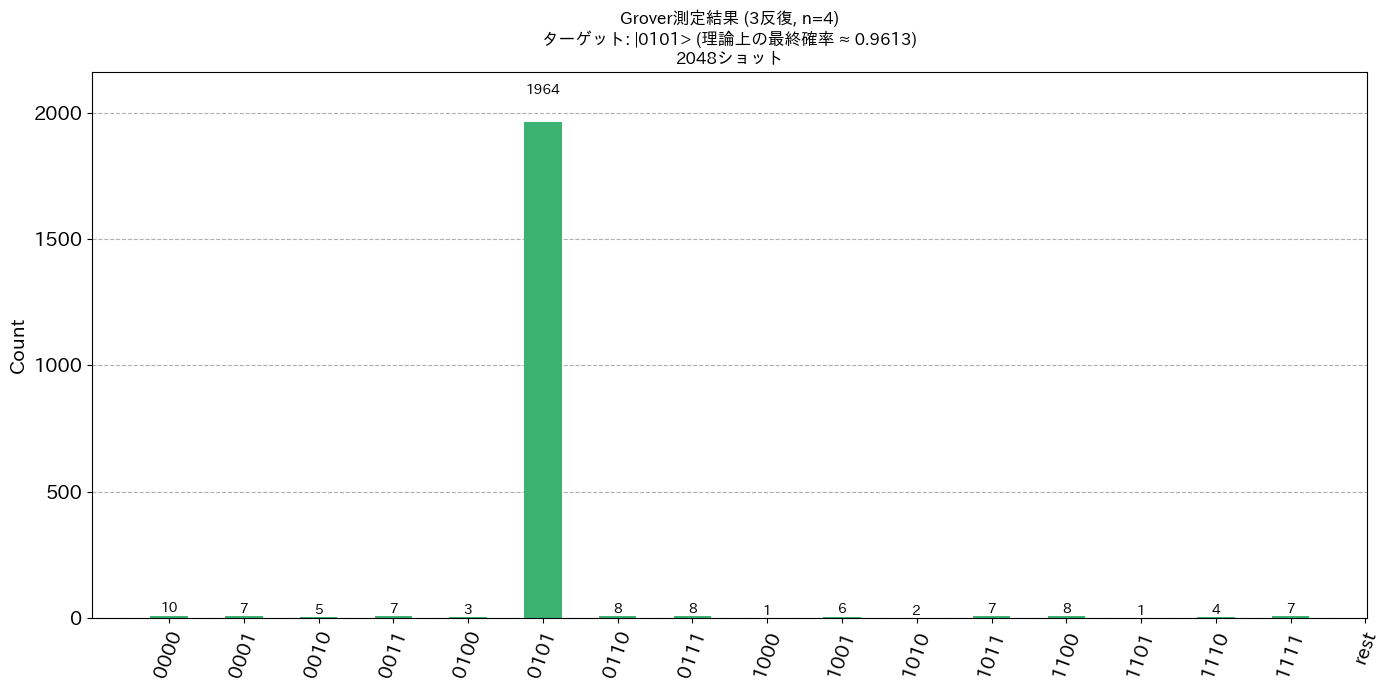


マークされた状態 |0101> が測定された回数: 1964 / 2048 ショット
  これにより得られた測定確率 (実験値): 0.9590
  比較のための理論上の最大確率: 0.9613

測定結果により、マークされた状態が高い確率で検出されることが確認できた。


In [44]:
# 最適回数反復後の状態を測定し、結果をヒストグラムで表示する
print(f"測定と結果の分析 (最適 {optimal_iters} 反復後)...")

# 測定用の量子回路を準備(内容は上記の full_grover_qc_draw と同じだが、名前を分けて管理)。
# full_grover_qc_draw には既に測定が含まれているため、それを利用。
qc_for_measure = full_grover_qc_draw # または、測定用に再構築しても良い

# 量子回路シミュレータを準備。
simulator = BasicSimulator()

# 回路をシミュレータ用にトランスパイル（最適化・変換）。
compiled_qc = transpile(qc_for_measure, simulator)

# シミュレーションを実行。shotsは測定の試行回数です。
shots = 2048 # 試行回数を増やせば、より理論値に近い分布が得られる。
job = simulator.run(compiled_qc, shots=shots)
result = job.result() # シミュレーション結果を取得

# 測定結果（各状態が測定された回数）を取得。
counts = result.get_counts(qc_for_measure)
print(f"\n{shots}回のショットによる測定結果 (カウント数):")
# print(counts) # 全てのカウントを表示すると長くなる場合があるので、主要なものだけ表示する工夫も可能

# 参考：最適状態におけるマークされたアイテムの理論的な最終確率 (sv_after_optimalより)
final_prob_optimal_marked_theory = sv_after_optimal.probabilities_dict().get(marked_item_binary, 0.0)

# 測定結果のヒストグラムをプロット。
print("\n測定結果のヒストグラム:")
fig_hist, ax_hist = plt.subplots(figsize=(14,7))
plot_histogram(
    counts,
    ax=ax_hist,
    title=f"Grover測定結果 ({optimal_iters}反復, n={n})\nターゲット: |{marked_item_binary}> (理論上の最終確率 ≈ {final_prob_optimal_marked_theory:.4f})\n{shots}ショット",
    number_to_keep=N, # 表示する状態の数を指定 (Nですべて表示)
    color='mediumseagreen'
)
fig_hist.tight_layout()
plt.show()
plt.close(fig_hist)

# マークされたアイテムが測定された回数と確率（実験値）
marked_item_counts = counts.get(marked_item_binary, 0)
measured_prob_marked = marked_item_counts / shots
print(f"\nマークされた状態 |{marked_item_binary}> が測定された回数: {marked_item_counts} / {shots} ショット")
print(f"  これにより得られた測定確率 (実験値): {measured_prob_marked:.4f}")
print(f"  比較のための理論上の最大確率: {final_prob_optimal_marked_theory:.4f}")

print(f"\n測定結果により、マークされた状態が高い確率で検出されることが確認できた。")

測定結果のヒストグラムを見ると、マークされた状態 $\ket{0101}$が他の状態に比べて圧倒的に高い頻度で測定されていることがわかる。
これは、Groverのアルゴリズムが意図した通りに機能し、探索対象のアイテムの確率振幅を効果的に増幅したことを示している。
理論的な最大確率とシミュレーションによる実験値も近い値になっている。

## 14. まとめ
ここまでで、Groverの量子検索アルゴリズムの主要な構成要素とその動作原理を追ってきた。

- 均一な重ね合わせ状態の生成: 全ての可能性を等しく含む初期状態 $\ket{s}$を準備した。
- オラクル $U_f$ の適用: 探索対象のアイテム $\ket{x_M}$ の位相を選択的に反転させた。
- ディフューザー $U_s$の適用: 全状態の振幅を平均値周りに反転させ、マークされたアイテムの振幅を増幅させた。
- Grover反復 $G=U_f U_s$​: オラクルとディフューザーの組を最適回数繰り返すことで、マークされたアイテムの測定確率を最大化した。
- 最適反復回数の重要性: 反復回数が少なすぎても多すぎても、探索効率が低下することを確認した。
- 測定: 最終的に、増幅された状態を測定することで、高確率でマークされたアイテムを検出できることを示した。

## 参考文献
- Quantum Native Dojo! https://dojo.qulacs.org/ja/latest/notebooks/8.2_Grovers_algorithm.html
- Qiskit Textbook https://github.com/Qiskit/textbook/blob/main/translations/ja/ch-algorithms/grover.ipynb
- Hatenablog https://sakumatcho.hatenablog.com/entry/2021/03/14/111649